In [1]:
import os
import math
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import soundfile as sf
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

# Chargement du fichier audio
musicFile = "musics/War.wav"
y,sr = librosa.load(musicFile)

# Création du mel-spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, power=1.0)

# Stockage des données concernant le tempo et les beats
tempo,beats = librosa.beat.beat_track(y=y, sr=sr)
beatsTime = librosa.frames_to_time(beats,sr=sr)

# Calcul du BPM
begin = beatsTime[0]
end = beatsTime[len(beatsTime)-1]

totalTime = end - begin
bpm = (len(beatsTime)-1)/(totalTime/60)

print("BPM :",round(bpm))

# Permet de faire la moyenne sur l'ensemble des données situées entre deux intervalles donnés
def beatIntervals(S,tab):
    # Initialisation à vide
    ret = []

    # Itération sur les indices des beats
    for i in range(len(tab)-1):

        # Indices de début et de fin
        firstIndex = tab[i]
        lastIndex = tab[i+1]

        # Extraction des valeurs
        indices = np.array(range(firstIndex,lastIndex))
        test = S[:,indices]

        # Calcul de la moyenne
        ret.append(np.mean(test,axis=1))
    
    # Conversion en NumPy-array et transposition
    ret = np.array(ret)
    ret = np.swapaxes(ret,1,0)    
    return ret

interBeats = beatIntervals(S,beats)

# Permet de calculer la matrice de distance entre les intervalles
def distanceMatrix(intervals):
    # Initialisation de la matrice carrée à 0
    mat = np.zeros((intervals.shape[1],intervals.shape[1]))
    for i in range(intervals.shape[1]):
        for j in range(i+1,intervals.shape[1]):

            # Calcul de la distance entre les intervalles i et j et remplissage de la matrice
            mat[i][j] = mat[j][i] = (sp.spatial.distance.euclidean(intervals[:,i],intervals[:,j]))
    return mat

matBeats = distanceMatrix(interBeats)

# Permet de construire la matrice de connectivité entre les beats
def buildBeatsConnectivityMatrix(matrix):
    ret = np.zeros((matrix.shape[1],matrix.shape[1]))
    for i in range(matrix.shape[1]):
        if i-1 >= 0:
            ret[i][i-1] = 1
        if i+1 < matrix.shape[1]:
            ret[i][i+1] = 1
    return ret

connectBeats = buildBeatsConnectivityMatrix(matBeats)

BPM : 128


In [2]:
# Permet de calculer les scores de Silhouette Coefficient, Calinski-Harabasz Index et Davies-Bouldin Index en fonction du nombre de clusters
silhouette_scores = np.empty((0))
calinski_harabasz_scores = np.empty((0))
davies_bouldin_scores = np.empty((0))
x = np.arange(12,26)

for i in x:
    clustering = AgglomerativeClustering(n_clusters=i,connectivity=buildBeatsConnectivityMatrix(connectBeats),metric='euclidean',linkage='ward',compute_full_tree=True)
    model = clustering.fit_predict(matBeats)
    labels = clustering.labels_

    silhouette_score = metrics.silhouette_score(matBeats, labels, metric='euclidean')
    calinski_harabasz_score = metrics.calinski_harabasz_score(matBeats, labels)
    davies_bouldin_score = metrics.davies_bouldin_score(matBeats, labels)

    silhouette_scores = np.append(silhouette_scores,silhouette_score)
    calinski_harabasz_scores = np.append(calinski_harabasz_scores,calinski_harabasz_score)
    davies_bouldin_scores = np.append(davies_bouldin_scores,davies_bouldin_score)

# Permet de classer les différents nombres de clusters en fonction des scores obtenus
def rankingBestNumberClusters(x,silhouette_scores,calinski_harabasz_scores,davies_bouldin_scores):
    sil_Ranks = np.zeros(x.shape[0])
    cal_ha_Ranks = np.zeros(x.shape[0])
    dav_bou_Ranks = np.zeros(x.shape[0])

    alt_sil = np.sort(silhouette_scores)[::-1]
    alt_cal = np.sort(calinski_harabasz_scores)[::-1]
    alt_dav = np.sort(davies_bouldin_scores)

    while alt_sil.shape[0] != 0:
        silMax = np.max(alt_sil)
        indice = np.where(silhouette_scores == silMax)[0][0]
        sil_Ranks[indice] = math.floor(x.shape[0] - alt_sil.shape[0] + 1)
        alt_sil = np.delete(alt_sil,0)

    while alt_cal.shape[0] != 0:
        calMax = np.max(alt_cal)
        indice = np.where(calinski_harabasz_scores == calMax)[0][0]
        cal_ha_Ranks[indice] = math.floor(x.shape[0] - alt_cal.shape[0] + 1)
        alt_cal = np.delete(alt_cal,0)

    while alt_dav.shape[0] != 0:
        davMin = np.min(alt_dav)
        indice = np.where(davies_bouldin_scores == davMin)[0][0]
        dav_bou_Ranks[indice] = math.floor(x.shape[0] - alt_dav.shape[0] + 1)
        alt_dav = np.delete(alt_dav,0)

    total = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        total[i] = sil_Ranks[i] + cal_ha_Ranks[i] + dav_bou_Ranks[i]

    total_Ranks = np.zeros(x.shape[0])
    copy = total.copy()

    while copy.shape[0] != 0:
        totalMin = np.min(copy)
        indice = np.where(total == totalMin)[0]
        for elt in indice:
            total_Ranks[elt] = math.floor(x.shape[0] - copy.shape[0] + 1)
        for elt in indice:
            copy = copy[copy != totalMin]

    final = np.empty((0))

    for rank in range(1,x.shape[0]+1):
        # for k in range(x.shape[0]):
        for k in range(x.shape[0]-1,-1,-1):
            if total_Ranks[k] == rank:
                final = np.append(final,x[k])

    return final[0]
    
idealClusterNb = rankingBestNumberClusters(x,silhouette_scores,calinski_harabasz_scores,davies_bouldin_scores)

In [3]:
# Permet de déterminer les clusters en fonction de la matrice de connectivité et du nombre de clusters
def determineClusters(matrix,idealClusterNb):
    clustering = AgglomerativeClustering(n_clusters=int(idealClusterNb),connectivity=matrix,metric='euclidean',linkage='ward',compute_full_tree=True)
    model = clustering.fit_predict(matBeats)

    labels = clustering.labels_

    # Minimum size of clusters
    min_cluster_size = 16

    # Calculate the size of each cluster
    cluster_sizes = np.bincount(model)

    # Order all the clusters by their minimal index
    clusters = np.argsort([np.min(np.where(model == i)[0]) for i in range(clustering.n_clusters_)])

    # Merge the two first clusters while they are smaller than the minimum size
    while cluster_sizes[clusters[0]] < min_cluster_size:
        model[model == clusters[0]] = clusters[1]
        cluster_sizes[clusters[1]] += cluster_sizes[clusters[0]]
        cluster_sizes[clusters[0]] = 0
        clusters = np.delete(clusters,0)

    # Find the clusters that are smaller than the minimum size
    small_clusters = np.where(cluster_sizes < min_cluster_size)[0]

    # Erase the labels of the small clusters which don't contain any beat
    for small_cluster in small_clusters:
        if cluster_sizes[small_cluster] == 0:
            small_clusters = np.delete(small_clusters,np.where(small_clusters == small_cluster))

    # Get the minimum index of each small cluster
    min_indices = [np.min(np.where(labels == i)[0]) for i in small_clusters]

    # Sort the small clusters in ascending order of their minimum index
    small_clusters = small_clusters[np.argsort(min_indices)]

    # For each small cluster
    for small_cluster in small_clusters:
        # Find the indices of the small cluster
        indices_small_cluster = np.where(model == small_cluster)[0]

        ### VERSION 1
        # Find the nearest larger cluster in terms of index proximity
        min_distance = np.inf
        nearest_larger_cluster = None
        for larger_cluster in np.where(cluster_sizes >= min_cluster_size)[0]:
            # Find the indices of the larger cluster
            indices_larger_cluster = np.where(model == larger_cluster)[0]

            if indices_larger_cluster[-1] < indices_small_cluster[0]:
                # Calculate the minimum absolute difference between the indices
                distance = np.min(np.abs(indices_small_cluster[:, None] - indices_larger_cluster))

                if distance < min_distance:
                    min_distance = distance
                    nearest_larger_cluster = larger_cluster
        # Merge the small cluster into the nearest larger cluster
        model[model == small_cluster] = nearest_larger_cluster

    cluster_sizes = np.bincount(model)

    clusters = []

    for i in range(clustering.n_clusters_+1):
        clusters.append(np.where(model == i))

    clusters = [x for x in clusters if len(x[0]) > 0]

    clusters.sort(reverse=False,key=lambda x : x[0][0])

    limits = np.zeros(len(clusters)*2)

    for i in range(len(clusters)):
        limits[2*i] = math.floor(clusters[i][0][0])
        limits[2*i+1] = math.floor(clusters[i][0][len(clusters[i][0])-1])

    limits = limits.reshape(-1,2)
    limits = np.int_(limits)

    return limits

limits = determineClusters(connectBeats,idealClusterNb)

# Permet de générer les parties de la musique en fonction des clusters
def generatePartsWithClusteringBeats(tab):
    donnees,samplerate = sf.read(musicFile)
    print("Durée de la musique :",donnees.shape[0]//(60*samplerate),"minutes",(donnees.shape[0]%(samplerate*60))//(samplerate),"secondes")

    for i in range(len(tab)):
        beginBeat = tab[i][0]
        endBeat = tab[i][1]

        beginTime = beatsTime[beginBeat]
        endTime = beatsTime[endBeat]

        if i == 0:
            beginData = 0
        else:
            beginData = math.floor(beginTime*samplerate)+1

        if i == len(tab)-1:
            endData = len(donnees)-1
        else:
            endTime = beatsTime[endBeat+1]
            endData = math.floor(endTime*samplerate)

        print(beginData,endData)

        data = donnees[beginData:endData]
        filename = "result/part"+str(i+1)+".wav"
        sf.write(filename,data,samplerate,'PCM_16')

if not os.path.exists("result"):
    os.makedirs("result")

generatePartsWithClusteringBeats(limits)

Durée de la musique : 3 minutes 52 secondes
0 722233
722234 1419946
1419947 2162242
2162243 2859955
2859956 3601136
3601137 4321140
4321141 4951980
4951981 6639420
6639421 7580107
7580108 8101720
8101721 8821725
8821726 9541729
9541730 10239442
10239443 11164687


14
22 627
(128,)
(128,)
648 1253
(128,)
(128,)
1274 1919
(128,)
(128,)
1940 2546
(128,)
(128,)
2566 3211
(128,)
(128,)
3231 3859
(128,)
(128,)
3877 4423
(128,)
(128,)
4443 5936
(128,)
(128,)
5957 6781
(128,)
(128,)
6801 7249
(128,)
(128,)
7269 7897
(128,)
(128,)
7915 8541
(128,)
(128,)
8561 9167
(128,)
(128,)
9187 9792
(128,)
(128,)
(28, 128)
(128, 28)


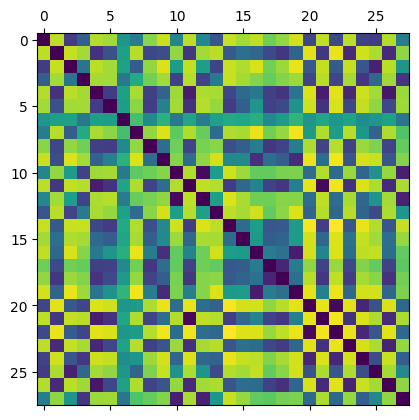

2.3691999912261963 31.888765335083008
2.5380136966705322 31.888765335083008
2.5449514389038086 31.888765335083008
[[11, 4], [21, 4], [19, 16]]
0 6
2 11
2 10
8 14


In [4]:
# Permet de générer une matrice de distance aux limites de chaque cluster
nbClusters = len(limits)
print(nbClusters)

elts = []
for elt in limits:
    print(beats[elt[0]],beats[elt[1]])
    print(S[:,beats[elt[0]]].shape)
    print(S[:,beats[elt[1]]].shape)
    elts.append(S[:,beats[elt[0]]])
    elts.append(S[:,beats[elt[1]]])

elts = np.array(elts)
print(elts.shape)
elts = np.swapaxes(elts,1,0)
print(elts.shape)

testMatrix = distanceMatrix(elts)
plt.matshow(testMatrix)
plt.show()

select = []
# Copie de la matrice de distances
data = np.copy(testMatrix)

# Suppression des valeurs nulles
indices = np.where(data != 0)
data = data[indices]

# Tri des valeurs
data = np.sort(data)

# Suppression des valeurs doublées
indices = np.arange(0,data.shape[0],2)
data = data[indices]

# Recherche des candidats potentiels pour la transition
for val in data:
    if len(select) < 3:
        for i in range(testMatrix.shape[0]):
            for j in range(i+1,testMatrix.shape[0]):
                if testMatrix[i][j] == val and np.abs(i-j) > 2 and np.abs(i-j)%2 == 1 and val/np.max(testMatrix) < 0.1:
                    print(val,np.max(testMatrix))
                    select.append([j,i])

print(select)

musicParts = []
tracks = []
transitions = []

# Permet de créer une piste audio à partir de deux indices
def createTrack(beginIndex,endIndex):
    track = np.concatenate(musicParts[beginIndex:endIndex])
    tracks.append(track)

# Extraction de chaque partie de la musique
for i in range(len(limits)):
    musicPart,sr = sf.read("result/part"+str(i+1)+".wav")
    musicParts.append(musicPart)

# Création du morceau final
for i in range(len(select)):
    if i == 0:
        begin = 0
        end = select[i][0]//2+1
        transitions.append([begin,end])

        createTrack(begin,end)
        print(begin,end)

        begin = select[i][1]//2
    elif i != len(select)-1:
        end = select[i][0]//2+1
        transitions.append([begin,end])

        createTrack(begin,end)
        print(begin,end)

        begin = select[i][1]//2
    else:
        end = select[i][0]//2+1
        transitions.append([begin,end])

        createTrack(begin,end)
        print(begin,end)

        begin = select[i][1]//2
        end = nbClusters
        transitions.append([begin,end])

        createTrack(begin,end)
        print(begin,end)

finalTrack = np.concatenate(tracks)
sf.write("result/final_track.wav",finalTrack,sr,"PCM_16")

for part in range(1,len(limits)+1):
    if os.path.exists("result/part"+str(part)+".wav"):
        os.remove("result/part"+str(part)+".wav")

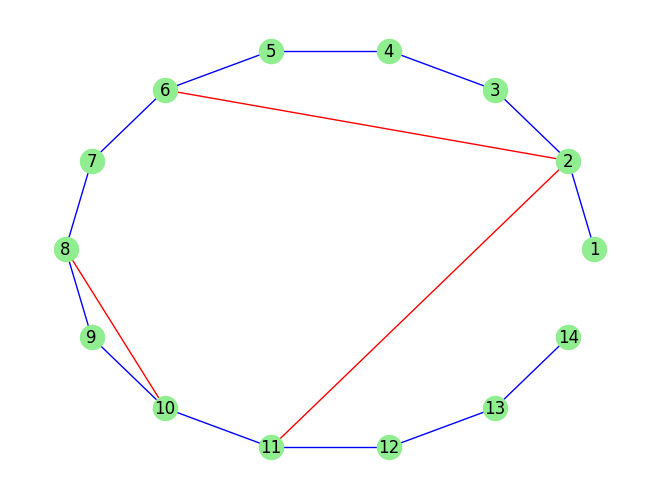

Bouclage terminé !


In [5]:
import networkx as nx

# Permet d'afficher les transitions entre les différents clusters sous forme de graphe circulaire
newTab = []

for i in range(len(transitions)-1):
    newTab.append([transitions[i][1],transitions[i+1][0]])
        

nbClusters = len(limits)
G = nx.Graph()

for i in range(nbClusters):
    G.add_node(i+1)

for i in range(nbClusters-1):
    G.add_edge(i+1,i+2,color="b",weight=2)

for elt in newTab:
    G.add_edge(elt[0],elt[1],color="r",weight=2)

graph = nx.circular_layout(G)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]

import matplotlib.pyplot as plt

nx.draw(G,graph,edge_color=colors,node_color="lightgreen",with_labels=True)
plt.show()

print("Bouclage terminé !")